# 血圧値ごとにデータの数を均等にする

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = r"../data/processed/BP_npy/1127_256_corr/p00"
DATA_DIR = r"../data/processed/BP_npy/0625_256_2_clean/p00"

In [4]:
scale = np.load(DATA_DIR+r"/scale_train.npy")
train = np.load(DATA_DIR+r"/train.npy")
test = np.load(DATA_DIR+r"/test.npy")
validate = np.load(DATA_DIR+r"/validate.npy")
scale.shape,train.shape,test.shape,validate.shape

((2, 2), (103258, 256, 2), (12643, 256, 2), (5894, 256, 2))

In [5]:
train_unscaled = (train[:,:,0]-scale[0,0]) / scale[0,1]
train_unscaled_ppg = (train[:,:,1]-scale[1,0]) / scale[1,1]
train_unscaled = np.stack([train_unscaled,train_unscaled_ppg],axis=-1)
train_unscaled_max = np.max(train_unscaled[:,:,0],axis=1)
train_unscaled_min = np.min(train_unscaled[:,:,0],axis=1)
train_unscaled.shape

(508728, 256, 2)

(array([ 9905., 36652., 66244., 85475., 84316., 73527., 61549., 45988.,
        29168., 15904.]),
 array([ 85.03758554,  94.53382698, 104.03006843, 113.52630988,
        123.02255132, 132.51879277, 142.01503422, 151.51127566,
        161.00751711, 170.50375855, 180.        ]),
 <BarContainer object of 10 artists>)

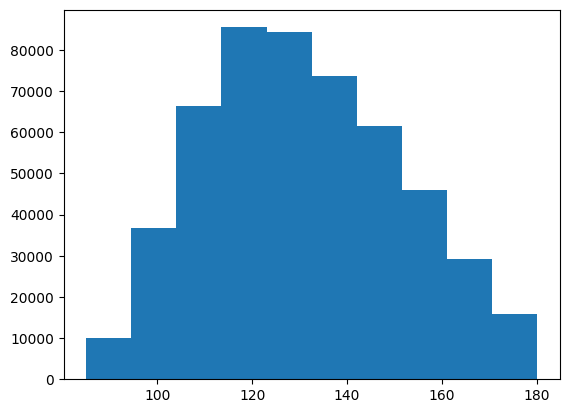

In [6]:
plt.hist(train_unscaled_max)

(array([126643., 161172., 104982.,  59535.,  32546.,  14938.,   5671.,
          1986.,    853.,    402.]),
 array([ 50.        ,  56.99805405,  63.99610811,  70.99416216,
         77.99221621,  84.99027026,  91.98832432,  98.98637837,
        105.98443242, 112.98248648, 119.98054053]),
 <BarContainer object of 10 artists>)

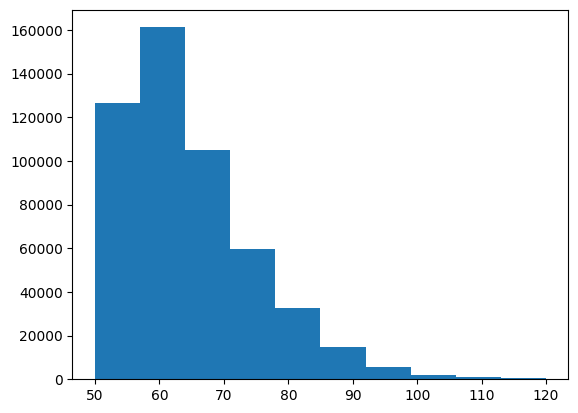

In [7]:
plt.hist(train_unscaled_min)

### AAMI doi: 10.1097/HJH.0000000000001634 2013. ANSI/AAMI/ISO 81060-2
* ≧5% of SBP ≦100 mmHg
* ≧5% of SBP ≧160 mmHg
* ≧20% of SBP ≧140 mmHg
* ≧5% of DBP ≦60 mmHg
* ≧5% of DBP ≧100 mmHg
* ≧20% of DBP ≧85 mmHg
### BHS doi: 10.1097/00004872-199007000-00004.
number of patients: 
|SBP|<90|90-129|130-160|161-180|>180|
|----|----|----|----|----|----|
|n|8|20|20|20|8|  

|DBP|<60|60-79|80-100|101-110|>110|
|----|----|----|----|----|----|
|n|8|20|20|20|8|  

In [8]:
def bp_density_check(bp,sbp=True):
    bp_mmhg = [100,160,140] if sbp else [60,100,85]
    threshold = [0.05,0.05,0.2]
    results = []
    ratios = []
    length = len(bp)
    idxs = []
    # 0
    idx = np.where(bp <= bp_mmhg[0])[0]
    ratio = len(idx)/length
    results.append(ratio>=threshold[0])
    ratios.append(ratio)
    idxs.append(idx)
    # 1
    idx = np.where(bp >= bp_mmhg[1])[0]
    ratio = len(idx)/length
    results.append(ratio>=threshold[1])
    ratios.append(ratio)
    idxs.append(idx)
    #2
    idx = np.where(bp >= bp_mmhg[2])[0]
    ratio = len(idx)/length
    results.append(ratio>=threshold[2])
    ratios.append(ratio)
    idxs.append(idx)
    return results,ratios,idxs

In [9]:
results,ratios,idxs_dbp = bp_density_check(train_unscaled_min,sbp=False)
print(results,ratios)

[True, False, False] [0.3901456180906103, 0.005549134311459169, 0.04687573713261311]


In [10]:
results,ratios,idxs_sbp = bp_density_check(train_unscaled_max)
print(results,ratios)

[True, True, True] [0.0524012832004529, 0.09726022550360901, 0.3281851991634036]


# 範囲とその割合を決める

In [11]:
# min_sbp:85 , max_sbp: 180
# min_dbp:50, max_dbp:120
sbp_distribution_bp = [85,100,120,140,160,180]
dbp_distribution_bp = [50,60,75,85,120]
bp_distribution_density = [20,20,20,20,20]
bp_distribution_density_2 = [11,26,26,26,11]
bp_distribution_density_3 = [25,30,25,20]

In [12]:
n = []
for i in range(4):
    tmp = []
    for j in range(5):
        tmp.append(len(np.where((train_unscaled_max >= sbp_distribution_bp[j])& (train_unscaled_max < sbp_distribution_bp[j+1])&(train_unscaled_min >= dbp_distribution_bp[i])& (train_unscaled_min < dbp_distribution_bp[i+1]))[0]))

    # n_dbp.append(len(np.where()[0]))
    n.append(tmp)
n    

[[19593, 87699, 62282, 24260, 4638],
 [6533, 47613, 96243, 60111, 21576],
 [526, 4995, 10448, 25573, 12791],
 [5, 1992, 3842, 7534, 10474]]

In [13]:
len(train_unscaled_max)

508728

In [14]:
p_sbp = [i/len(train_unscaled_max)for i in n_sbp]
p_dbp = [i/len(train_unscaled_max)for i in n_dbp]
p_sbp,p_dbp

NameError: name 'n_sbp' is not defined

In [15]:
len(train_unscaled_max) *0.017353084555990626/0.25

35312.0

In [191]:
8828* 14.406660625283191

127182.00000000001

In [16]:
sbp_samples = [55960,	132269,	132269,	132269,	55960]
sbp_class = np.zeros(len(train_unscaled_max))
sbp_class -=1
for i in range(5):
    idx = np.where((train_unscaled_max >= sbp_distribution_bp[i])& (train_unscaled_max < sbp_distribution_bp[i+1]))[0]
    sbp_class[idx] = i

In [17]:
sbp_samples = [int(i/1.695757575757576)+1 for i in sbp_samples]
sbp_samples

[33000, 78000, 78000, 78000, 33000]

In [18]:
np.unique(sbp_class,return_counts=True)

(array([0., 1., 2., 3., 4.]),
 array([ 26657, 142299, 172815, 117478,  49479], dtype=int64))

In [19]:
from sklearn.utils import resample
resampled_data = [
    resample(train_unscaled[sbp_class == c],
             replace=len(sbp_class[sbp_class == c]) < sbp_samples[c],  # 少ないクラスはアップサンプリング
             n_samples=sbp_samples[c],  # 目標サンプル数
             random_state=42)
    for c in range(5)
]

In [20]:
[i.shape for i in resampled_data]

[(33000, 256, 2),
 (78000, 256, 2),
 (78000, 256, 2),
 (78000, 256, 2),
 (33000, 256, 2)]

In [21]:
train_balanced=np.concatenate(resampled_data)
train_balanced.shape

(300000, 256, 2)

In [22]:
train_balanced.max()

179.99999999999997

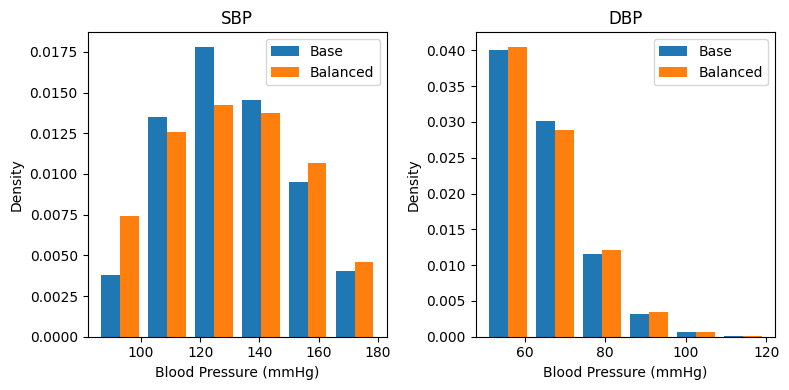

In [38]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist([train_unscaled_max,np.max(train_balanced[:,:,0],axis=1)],bins=6,histtype='bar',label=["Base","Balanced"],density=True)
plt.title("SBP")
plt.ylabel("Density")
plt.xlabel("Blood Pressure (mmHg)")
plt.legend()
plt.subplot(122)
plt.hist([train_unscaled_min,np.min(train_balanced[:,:,0],axis=1)],bins=6,histtype='bar',label=["Base","Balanced"],density=True)
plt.title("DBP")
plt.ylabel("Density")
plt.xlabel("Blood Pressure (mmHg)")
plt.legend()
plt.tight_layout()

In [ ]:
plt.hist([train_unscaled_max,np.max(train_balanced[:,:,0],axis=1)],bins=6,histtype='bar',label=["base","balanced"],density=True)
plt.legend()

In [201]:
test[:,:,1] = (test[:,:,1] -scale[1,0]) / scale[1,1]
validate[:,:,1] = (validate[:,:,1] -scale[1,0]) / scale[1,1]
validate[:,:,0] = (validate[:,:,0]-scale[0,0]) / scale[0,1]
test[:,:,0] = (test[:,:,0]-scale[0,0]) / scale[0,1]

In [202]:
from sklearn.preprocessing import MinMaxScaler
def scale_(train,val,test,px=256):
    scaler_ppg = MinMaxScaler()
    scaler_abp = MinMaxScaler()
    train[:,:,0] = scaler_abp.fit_transform(train[:,:,0].reshape(-1,1)).reshape(-1,px)
    val[:,:,0] = scaler_abp.transform(val[:,:,0].reshape(-1,1)).reshape(-1,px)
    test[:,:,0] = scaler_abp.transform(test[:,:,0].reshape(-1,1)).reshape(-1,px)
    train[:,:,1] = scaler_ppg.fit_transform(train[:,:,1].reshape(-1,1)).reshape(-1,px)
    val[:,:,1] = scaler_ppg.transform(val[:,:,1].reshape(-1,1)).reshape(-1,px)
    test[:,:,1] = scaler_ppg.transform(test[:,:,1].reshape(-1,1)).reshape(-1,px)
    params = np.zeros((2,2))
    params[0,0] = scaler_abp.min_[0]
    params[0,1] = scaler_abp.scale_[0]
    params[1,0] = scaler_ppg.min_[0]
    params[1,1] = scaler_ppg.scale_[0]
    return train,val,test,params

In [204]:
train,val,test,params = scale_(train_balanced,validate,test)

In [205]:
val.max(),test.max(),params,train.max()

(0.9999685423463662,
 0.9999271095674708,
 array([[-0.38461538,  0.00769231],
        [ 0.41712773,  1.58669997]]),
 1.0)

In [ ]:
SAVE_DIR = r"../data/processed/BP_npy/1127_256_balanced/p00"
os.makedirs(SAVE_DIR,exist_ok=True)
np.save(os.path.join(SAVE_DIR,"scale_train.npy"),params)
np.save(os.path.join(SAVE_DIR,"train.npy"),train)
np.save(os.path.join(SAVE_DIR,"test.npy"),test)
np.save(os.path.join(SAVE_DIR,"validate.npy"),val)